In [20]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from scipy import stats

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

from lifelines import CoxPHFitter

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.util import Surv
from sksurv.metrics import (concordance_index_censored,
                            concordance_index_ipcw,
                            cumulative_dynamic_auc)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as shc

## read in and create dfs 

### demogs

In [21]:
path_demogs = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_demogs.xlsx'

demogs = pd.read_excel(path_demogs)

demogs = demogs.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(demogs.shape)
print(len(demogs['SLS #'].unique()))

demogs.sort_values('SLS #').head()

(1104, 14)
1104


,SLS #,BIRTHYR,COHORT,DEATHYR,Age at first test condition,Year of Last Test,Age at Last testing Condition,Ethnicity,GENDER (m=1),APOE Status,Education,HBQ Median Sleep Duration,Average Sleep,Median Sleep
949,101530,1915,5,2006.0,62,2004,89,NaN,1,3/3,12,long_sleeper,7.333333,8.0
860,101910,1919,5,2008.0,58,2005,86,1.0,1,3/3,14,long_sleeper,9.000000,9.0
1056,111101,1911,4,2009.0,66,2005,94,1.0,1,2/3,8,medium_sleeper,6.666667,7.0
998,111401,1914,5,2005.0,63,2004,90,1.0,1,3/4,14,short_sleeper,6.500000,6.5
529,111702,1917,5,2010.0,60,1993,76,6.0,1,3/3,12,long_sleeper,8.000000,8.0


### sleep

In [22]:
path_sleep = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_sleep.xlsx'

sleep = pd.read_excel(path_sleep)

sleep = sleep.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(sleep.shape)
print(len(sleep['SLS_ID'].unique()))

sleep.sort_values('SLS_ID').head()

(1104, 6)
1104


,SLS_ID,1993_sleep,1998_sleep,2005_sleep,2008_sleep,2012_sleep
665,101530,8.0,8.0,6.0,NaN,NaN
666,101910,9.0,9.0,NaN,NaN,NaN
318,111101,7.0,6.0,7.0,NaN,NaN
1005,111401,6.0,7.0,NaN,NaN,NaN
1006,111702,8.0,NaN,NaN,NaN,NaN


### health

In [23]:
path_health = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_health.xlsx'

health = pd.read_excel(path_health)

health = health.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(health.shape)
print(len(health['SLS #'].unique()))

health.sort_values('SLS #').head()

(1104, 26)
1104


,SLS #,BMI 1993,BMI 1998,BMI 2005,BMI 2008,BMI 2012,DIABTS 1993,DIABTS 1998,DIABTS 2005,DIABTS 2008,DIABTS 2012,HTN 1993,HTN 1998,HTN 2005,HTN 2008,HTN 2012,SMOKYN 93,SMOKYN 98,SMOKYN 2005,SMOKYN 2008,SMOKYN 2012,USEALC 93,USEALC 98,USEALC 2005,USEALC 2008,USEALC 2012
3,101530,NaN,32.078031,29.288637,16.736364,16.736364,NaN,2.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,3.0,3.0,3.0,NaN,NaN
703,101910,NaN,29.649226,31.017652,29.534416,NaN,NaN,2.0,2.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN
148,111101,21.894813,22.807097,23.806226,23.806226,23.887484,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,2.0,2.0,2.0,NaN,NaN,5.0,4.0,2.0,NaN,NaN
1014,111401,26.580974,25.848043,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
687,111702,NaN,25.726782,27.124489,27.802602,NaN,NaN,2.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


### cog testing and depression


In [24]:
path_cognition = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Clinical projects/SLS/data/SLS_cog_dep.xlsx'

cognition = pd.read_excel(path_cognition)

cognition = cognition.replace({-888: np.nan, 'Not Recorded': np.nan, -999: np.nan, ' .': np.nan, '.': np.nan})

print(len(cognition.dropna(subset=['OCCSN'], axis=0)['IDNUM'].unique()))

#drop rows with no data
cognition = cognition.dropna(subset=['OCCSNDT'], axis=0)

print(cognition.shape)
cognition.head()

1104
(3729, 18)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score
0,101530,1,1998.0,30.0,139.0,118.0,13.0,12.0,14.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,101530,2,2001.0,28.0,141.0,101.0,14.0,14.0,14.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
2,101530,3,2004.0,29.0,139.0,73.0,17.0,14.0,10.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
7,101910,1,2001.0,27.0,135.0,274.0,10.0,10.0,10.0,11.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0
8,101910,2,2005.0,26.0,126.0,192.0,9.0,12.0,7.0,9.0,7.0,1.0,1.0,1.0,1.0,4.0,0.0,6.0


## add demogs and compute age data

In [25]:
#add in birth year from demogs
demogs_cognition = pd.merge(cognition, demogs[['SLS #', 'BIRTHYR', 'COHORT', 
                                          'Ethnicity', 'GENDER (m=1)', 'APOE Status', 'Education']], left_on=['IDNUM'], right_on=['SLS #'], sort=False)

#compute age for each occsn 
demogs_cognition['test_age'] = demogs_cognition['OCCSNDT'] - demogs_cognition['BIRTHYR']

print(cognition.shape)
print(demogs_cognition.shape)
demogs_cognition.head()

(3729, 18)
(3729, 26)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,test_age
0,101530,1,1998.0,30.0,139.0,118.0,13.0,12.0,14.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,101530,1915,5,NaN,1,3/3,12,83.0
1,101530,2,2001.0,28.0,141.0,101.0,14.0,14.0,14.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,101530,1915,5,NaN,1,3/3,12,86.0
2,101530,3,2004.0,29.0,139.0,73.0,17.0,14.0,10.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,101530,1915,5,NaN,1,3/3,12,89.0
3,101910,1,2001.0,27.0,135.0,274.0,10.0,10.0,10.0,11.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0,101910,1919,5,1.0,1,3/3,14,82.0
4,101910,2,2005.0,26.0,126.0,192.0,9.0,12.0,7.0,9.0,7.0,1.0,1.0,1.0,1.0,4.0,0.0,6.0,101910,1919,5,1.0,1,3/3,14,86.0


## Compute dementia, sleep, and health data


### find age where reached dementia criteria (score of 1 and above)


In [26]:
data_dementia = pd.DataFrame()

for ID in demogs_cognition['IDNUM'].unique():
    #print(ID)
    d=demogs_cognition[demogs_cognition['IDNUM'] == ID].sort_values('OCCSN')
    
    #determine earliest time point when criteria was met
    try:
        dd=d[d['Dementia Criteria Met']>1].sort_values('OCCSN').iloc[0]
        dd['dementia'] = 1
        row = pd.DataFrame(data=dd).T
        
    #if never reached criteria then take age at last visit
    except:
        dd=d.iloc[-1]
        dd['dementia'] = 0
        row = pd.DataFrame(data=dd).T

    if data_dementia.shape[0] < 1:
        data_dementia = row
    else:
        data_dementia = pd.concat([data_dementia, row], ignore_index=True)
        
print(data_dementia.shape)
data_dementia.head()

(1104, 27)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,test_age,dementia
0,101530,3,2004,29,139,73,17,14,10,13,10,0,0,0,0,0,0,13,101530,1915,5,NaN,1,3/3,12,89,0
1,101910,1,2001,27,135,274,10,10,10,11,10,1,0,1,0,2,0,7,101910,1919,5,1,1,3/3,14,82,1
2,111101,1,2003,24,120,285,8,9,10,8,8,1,1,1,1,4,2,8,111101,1911,4,1,1,2/3,8,92,1
3,111401,1,1998,20,119,163,9,10,7,8,7,1,1,0,1,3,1,4,111401,1914,5,1,1,3/4,14,84,1
4,111702,1,1997,25,117,121,4,7,10,12,4,1,1,0,1,3,2,17,111702,1917,5,6,1,3/3,12,80,1


In [27]:
data_dementia = data_dementia.infer_objects()

### compute sleep data (up to and including visit dementia yes/no)


In [38]:
sleep_count = []
sleep_count_final = []
sleep_keep = []
sleep_final_year = []

sleep_first = []
sleep_last = []

sleep_mean = []
sleep_median = []
sleep_std = []
sleep_slope = []
sleep_slope_int = []
sleep_slope_r = []
sleep_slope_p = []
sleep_slope_stderr = []

sleep_params = ['1993_sleep', '1998_sleep', '2005_sleep', '2008_sleep', '2012_sleep',]

for index, row in data_dementia.iterrows():
    
    #figure out how many sleep values to keep (only up to/including their dementia yes/no tp)
    if row['OCCSNDT'] >= 2012:
        count = 5
    elif (row['OCCSNDT'] >= 2008) & (row['OCCSNDT'] < 2012):
        count = 4
    elif (row['OCCSNDT'] >= 2005) & (row['OCCSNDT'] < 2008):
        count = 3
    elif (row['OCCSNDT'] >= 1998) & (row['OCCSNDT'] < 2005):
        count = 2
    elif (row['OCCSNDT'] >= 1993) & (row['OCCSNDT'] < 1998):
        count = 1
    elif row['OCCSNDT'] < 1993:
        count = 0
        
    sleep_count.append(count)   

    #get sleep data up to and including final time point (dementia yes/no)
    d_sleep = sleep[sleep['SLS_ID'] == row['IDNUM']][sleep_params[0:count]].dropna(axis=1)
    #get count of how many sleep data points were used (sleep count above might include nans)
    sleep_count_final.append(d_sleep.shape[1])
    
    #compute sleep params - requires at least 2 
    if d_sleep.shape[1] < 3:
        sleep_keep.append(0)
        sleep_final_year.append(0)
        sleep_first.append(np.nan)
        sleep_last.append(np.nan)
        sleep_mean.append(np.nan)
        sleep_median.append(np.nan)
        sleep_std.append(np.nan)
        sleep_slope.append(np.nan)
        sleep_slope_int.append(np.nan)
        sleep_slope_r.append(np.nan)
        sleep_slope_p.append(np.nan)
        sleep_slope_stderr.append(np.nan)
    else:
        sleep_keep.append(1)
        sleep_final_year.append(d_sleep.columns.values[-1])
        sleep_first.append(d_sleep.values[0][0])
        sleep_last.append(d_sleep.values[0][-1])
        sleep_mean.append(d_sleep.mean(axis=1).values[0])
        sleep_median.append(d_sleep.median(axis=1).values[0])
        sleep_std.append(d_sleep.std(axis=1).values[0])
        
        y=list(d_sleep.values[0])
        x=list(np.arange(0,len(y)))
        slope = stats.linregress(x, y)
        sleep_slope.append(slope[0])
        sleep_slope_int.append(slope[1])
        sleep_slope_r.append(slope[2])
        sleep_slope_p.append(slope[3])
        sleep_slope_stderr.append(slope[4])

data_dementia['sleep_keep'] = sleep_keep    
data_dementia['sleep_count'] = sleep_count
data_dementia['sleep_count_final'] = sleep_count_final
data_dementia['sleep_final_year'] = sleep_final_year 
data_dementia['sleep_first'] = sleep_first
data_dementia['sleep_last'] = sleep_last
data_dementia['sleep_mean'] = sleep_mean
data_dementia['sleep_median'] = sleep_median
data_dementia['sleep_std'] = sleep_std
data_dementia['sleep_slope'] = sleep_slope
data_dementia['sleep_slope_int'] = sleep_slope_int
data_dementia['sleep_slope_r'] = sleep_slope_r
data_dementia['sleep_slope_p'] = sleep_slope_p
data_dementia['sleep_slope_stderr'] = sleep_slope_stderr


print(data_dementia.shape)
data_dementia.head()

(1104, 41)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_final_year,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr
0,101530,3,2004.0,29.0,139.0,73.0,17.0,14.0,10.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,101530,1915,5,NaN,1,3/3,12,89.0,0,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101910,1,2001.0,27.0,135.0,274.0,10.0,10.0,10.0,11.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0,101910,1919,5,1.0,1,3/3,14,82.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,111101,1,2003.0,24.0,120.0,285.0,8.0,9.0,10.0,8.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0,8.0,111101,1911,4,1.0,1,2/3,8,92.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,111401,1,1998.0,20.0,119.0,163.0,9.0,10.0,7.0,8.0,7.0,1.0,1.0,0.0,1.0,3.0,1.0,4.0,111401,1914,5,1.0,1,3/4,14,84.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,111702,1,1997.0,25.0,117.0,121.0,4.0,7.0,10.0,12.0,4.0,1.0,1.0,0.0,1.0,3.0,2.0,17.0,111702,1917,5,6.0,1,3/3,12,80.0,1,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_dementia.groupby(['dementia'])['sleep_keep'].value_counts()

dementia  sleep_keep
0         1             655
          0             193
1         0             137
          1             119
Name: sleep_keep, dtype: int64

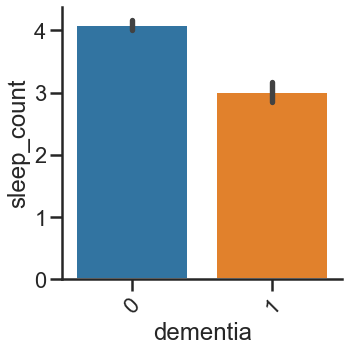

In [32]:
sns.catplot(x='dementia', y='sleep_count', data=data_dementia, kind='bar',)
plt.xticks(rotation = 45)
plt.show()

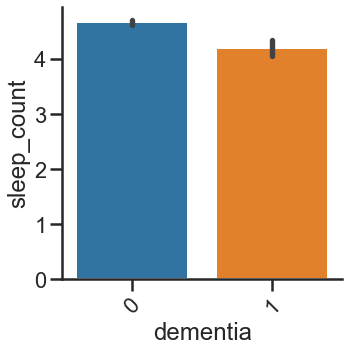

In [33]:
sns.catplot(x='dementia', y='sleep_count', data=data_dementia[data_dementia['sleep_keep']==1], kind='bar',)
plt.xticks(rotation = 45)
plt.show()

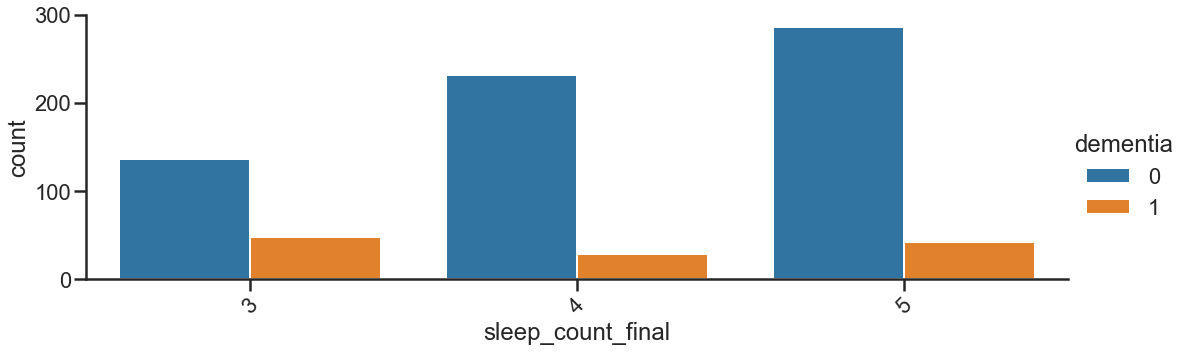

In [34]:
sleep_counts = data_dementia[data_dementia['sleep_keep']==1].groupby('sleep_count_final')['dementia'].value_counts().reset_index(name='count')
sns.catplot(x='sleep_count_final', y='count', data=sleep_counts, kind='bar', hue='dementia', height=5, aspect=3)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
sleep_params = ['sleep_count', 'sleep_count_final', 'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_median', 'sleep_std', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',]

for param in sleep_params:
    print(param)
    try:
        sns.catplot(x='dementia', y=param, kind='bar', ci=68, data=data_dementia[data_dementia['sleep_keep']==1], height=5, aspect=1)
        plt.show()
    except:
        print('no')

In [ ]:
data_dementia[data_dementia['sleep_keep']==1][['sleep_count_final', 'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_median', 'sleep_std', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',]].corr()

In [ ]:
sns.pairplot(data_dementia[data_dementia['sleep_keep']==1][['sleep_count_final', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',]])

### get health data corresponding to visit with dementia yes/no


In [41]:
BMI = []
DIABTS = []
HTN = []
SMOKING = []
ALCOHOL = []

BMI_params = ['BMI 1993', 'BMI 1998', 'BMI 2005', 'BMI 2008', 'BMI 2012',]
DIABTS_params = ['DIABTS 1993', 'DIABTS 1998', 'DIABTS 2005', 'DIABTS 2008', 'DIABTS 2012',]
HTN_params = ['HTN 1993', 'HTN 1998', 'HTN 2005', 'HTN 2008', 'HTN 2012',]
SMOKING_params = ['SMOKYN 93', 'SMOKYN 98', 'SMOKYN 2005', 'SMOKYN 2008', 'SMOKYN 2012']
ALCOHOL_params = ['USEALC 93', 'USEALC 98', 'USEALC 2005', 'USEALC 2008', 'USEALC 2012']

for index, row in data_dementia.iterrows():
    
    #get which visit is the final data point (same as sleep count (number of visits including the dementia yes/no))
    sleep_count = row['sleep_count']
    #print(sleep_count)
    
    #get data for final time point (dementia yes/no)
    d_int = health[health['SLS #'] == row['IDNUM']]
    #print(d_int)
    
    BMI.append(d_int[BMI_params[sleep_count - 1]].values[0])
    DIABTS.append(d_int[DIABTS_params[sleep_count - 1]].values[0])
    HTN.append(d_int[HTN_params[sleep_count - 1]].values[0])
    SMOKING.append(d_int[SMOKING_params[sleep_count - 1]].values[0])
    ALCOHOL.append(d_int[ALCOHOL_params[sleep_count - 1]].values[0])

data_dementia['BMI'] = BMI    
data_dementia['DIABTS'] = DIABTS
data_dementia['HTN'] = HTN
data_dementia['SMOKING'] = SMOKING
data_dementia['ALCOHOL'] = ALCOHOL

print(data_dementia.shape)
data_dementia.head()

(1104, 46)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_final_year,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,BMI,DIABTS,HTN,SMOKING,ALCOHOL
0,101530,3,2004.0,29.0,139.0,73.0,17.0,14.0,10.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,101530,1915,5,NaN,1,3/3,12,89.0,0,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.078031,2.0,1.0,2.0,3.0
1,101910,1,2001.0,27.0,135.0,274.0,10.0,10.0,10.0,11.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0,101910,1919,5,1.0,1,3/3,14,82.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.649226,2.0,2.0,2.0,7.0
2,111101,1,2003.0,24.0,120.0,285.0,8.0,9.0,10.0,8.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0,8.0,111101,1911,4,1.0,1,2/3,8,92.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.807097,2.0,2.0,2.0,4.0
3,111401,1,1998.0,20.0,119.0,163.0,9.0,10.0,7.0,8.0,7.0,1.0,1.0,0.0,1.0,3.0,1.0,4.0,111401,1914,5,1.0,1,3/4,14,84.0,1,0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.848043,2.0,2.0,3.0,1.0
4,111702,1,1997.0,25.0,117.0,121.0,4.0,7.0,10.0,12.0,4.0,1.0,1.0,0.0,1.0,3.0,2.0,17.0,111702,1917,5,6.0,1,3/3,12,80.0,1,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,4.0


## Survival curves


### Only use participants with slope data (at least 3 sleep data point)


In [42]:
data_dementia_sleep = data_dementia[data_dementia['sleep_keep']==1]
data_dementia_sleep_55 = data_dementia_sleep[data_dementia_sleep['test_age']>54]

print(data_dementia_sleep.shape)
print(data_dementia_sleep_55.shape)

data_dementia_sleep.head()

(774, 46)
(704, 46)


,IDNUM,OCCSN,OCCSNDT,MMSE TOTAL,MATTIS TOTAL,TRAIL B,WAASV - Vocabulary Age-Scaled Score,WAASC - Comprehension Age-Scaled Score,WAASBD - Block Design Age-Scaled Score,WAASSY Digit-Symbol Age-Scaled Score,Any score ≤ 8 / Lowest Score,Dementia Criteria MMSE ≤ 27,Dementia Criteria MATTIS ≤ 130,Dementia Criteria Trail B ≥ 180,Dementia Criteria WAIS ≤ 8,Dementia Criteria Met,CESD-11 Restlessness,CESD Total Score,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_final_year,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,BMI,DIABTS,HTN,SMOKING,ALCOHOL
7,116537,3,2005.0,29.0,142.0,122.0,11.0,9.0,13.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,5.0,116537,1921,6,1.0,2,NaN,14,84.0,0,1,3,3,2005_sleep,8.0,7.0,7.333333,7.0,0.57735,-0.5,7.833333,-0.866025,0.333333,0.288675,42.568496,2.0,1.0,2.0,7.0
8,126007,3,2012.0,3.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN,126007,1921,6,1.0,1,3/3,14,91.0,1,1,5,4,2008_sleep,6.0,6.0,6.250000,6.0,0.50000,0.1,6.100000,0.258199,0.741801,0.264575,26.499243,NaN,NaN,NaN,NaN
9,127504,3,2007.0,27.0,132.0,259.0,12.0,10.0,13.0,12.0,10.0,1.0,0.0,1.0,0.0,2.0,0.0,7.0,127504,1934,7,1.0,2,2/4,20,73.0,1,1,3,3,2005_sleep,8.0,8.0,8.000000,8.0,0.00000,0.0,8.000000,0.000000,1.000000,0.000000,24.268115,2.0,1.0,3.0,7.0
12,132093,4,2008.0,30.0,139.0,99.0,13.0,11.0,12.0,12.0,11.0,0.0,0.0,0.0,0.0,0.0,3.0,21.0,132093,1920,5,1.0,2,3/3,18,88.0,0,1,4,3,2005_sleep,7.0,7.0,7.000000,7.0,0.00000,0.0,7.000000,0.000000,1.000000,0.000000,NaN,2.0,NaN,NaN,NaN
17,134513,3,2007.0,28.0,142.0,189.0,14.0,13.0,17.0,9.0,9.0,0.0,0.0,1.0,0.0,1.0,2.0,15.0,134513,1907,4,1.0,2,3/3,18,100.0,0,1,3,3,2005_sleep,8.0,8.0,8.000000,8.0,0.00000,0.0,8.000000,0.000000,1.000000,0.000000,33.656509,2.0,2.0,3.0,3.0


### Compute time between final sleep and final dementia


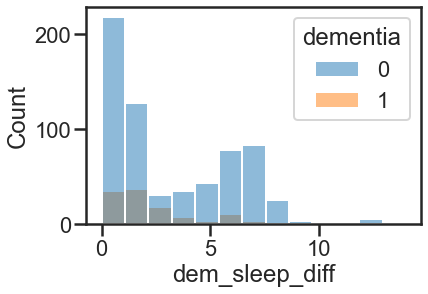

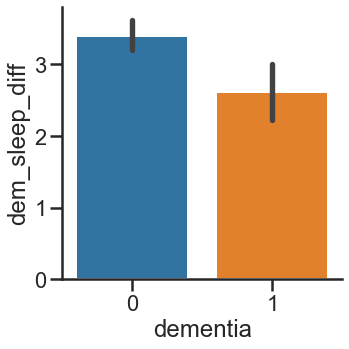

In [51]:
data_dementia_sleep['sleep_final_year'] = [int(str(x).split('_')[0]) for x in data_dementia_sleep['sleep_final_year']]
data_dementia_sleep['dem_sleep_diff'] = data_dementia_sleep['OCCSNDT'] - data_dementia_sleep['sleep_final_year']

sns.histplot(data=data_dementia_sleep, x='dem_sleep_diff', hue='dementia')
plt.show()

sns.catplot(x='dementia', y='dem_sleep_diff', data=data_dementia_sleep, kind='bar',)
plt.show()

In [52]:
data_final = data_dementia_sleep[['IDNUM', 'SLS #', 'BIRTHYR', 'COHORT',  
                     'Ethnicity', 'GENDER (m=1)', 'APOE Status', 'Education', 
                     'OCCSN', 'OCCSNDT', 'test_age', 'dementia', 'sleep_keep', 'sleep_count',
       'sleep_count_final', 'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_median', 'sleep_std', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',
                                   'CESD-11 Restlessness', 'CESD Total Score']]

print(data_final.shape)
data_final.head()

(774, 27)


,IDNUM,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,OCCSN,OCCSNDT,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,CESD-11 Restlessness,CESD Total Score
7,116537,116537,1921,6,1.0,2,NaN,14,3,2005.0,84.0,0,1,3,3,8.0,7.0,7.333333,7.0,0.57735,-0.5,7.833333,-0.866025,0.333333,0.288675,0.0,5.0
8,126007,126007,1921,6,1.0,1,3/3,14,3,2012.0,91.0,1,1,5,4,6.0,6.0,6.250000,6.0,0.50000,0.1,6.100000,0.258199,0.741801,0.264575,NaN,NaN
9,127504,127504,1934,7,1.0,2,2/4,20,3,2007.0,73.0,1,1,3,3,8.0,8.0,8.000000,8.0,0.00000,0.0,8.000000,0.000000,1.000000,0.000000,0.0,7.0
12,132093,132093,1920,5,1.0,2,3/3,18,4,2008.0,88.0,0,1,4,3,7.0,7.0,7.000000,7.0,0.00000,0.0,7.000000,0.000000,1.000000,0.000000,3.0,21.0
17,134513,134513,1907,4,1.0,2,3/3,18,3,2007.0,100.0,0,1,3,3,8.0,8.0,8.000000,8.0,0.00000,0.0,8.000000,0.000000,1.000000,0.000000,2.0,15.0


In [53]:
covariates = ['Education', 'APOE Status', 'CESD Total Score', 'GENDER (m=1)', 'Ethnicity',
             'CESD-11 Restlessness', 'CESD Total Score', ]

for param in covariates:
    print(param, ' missing: ', data_final[param].isna().sum())

Education  missing:  0
APOE Status  missing:  161
CESD Total Score  missing:  10
GENDER (m=1)  missing:  0
Ethnicity  missing:  21
CESD-11 Restlessness  missing:  11
CESD Total Score  missing:  10


In [54]:
data_final_nona = data_final.dropna(axis=0)
print(data_final_nona.shape)
data_final_nona.isna().sum()

(586, 27)


IDNUM                   0
SLS #                   0
BIRTHYR                 0
COHORT                  0
Ethnicity               0
GENDER (m=1)            0
APOE Status             0
Education               0
OCCSN                   0
OCCSNDT                 0
test_age                0
dementia                0
sleep_keep              0
sleep_count             0
sleep_count_final       0
sleep_first             0
sleep_last              0
sleep_mean              0
sleep_median            0
sleep_std               0
sleep_slope             0
sleep_slope_int         0
sleep_slope_r           0
sleep_slope_p           0
sleep_slope_stderr      0
CESD-11 Restlessness    0
CESD Total Score        0
dtype: int64

### Clean and update covariates


In [55]:
print(data_final_nona['APOE Status'].value_counts())

data_final_nona['APOE_bool'] = [1 if '4' in str(x).split('/') else 0 for x in data_final_nona['APOE Status']]

print(data_final_nona['APOE_bool'].value_counts())

3/3    347
3/4    120
2/3    75 
2/4    20 
4/4    19 
2/2    5  
Name: APOE Status, dtype: int64
0    427
1    159
Name: APOE_bool, dtype: int64


In [56]:
print(data_final_nona['Ethnicity'].value_counts())

data_final_nona['Ethnicity_bool'] = [1 if x==1 else 0 for x in data_final_nona['Ethnicity']]

print(data_final_nona['Ethnicity_bool'].value_counts())

1.0    559
3.0    9  
4.0    6  
2.0    5  
6.0    5  
5.0    2  
Name: Ethnicity, dtype: int64
1    559
0    27 
Name: Ethnicity_bool, dtype: int64


In [57]:
data_final_nona = data_final_nona.infer_objects()
print(data_final_nona.dtypes)

IDNUM                   int64  
SLS #                   int64  
BIRTHYR                 int64  
COHORT                  int64  
Ethnicity               float64
GENDER (m=1)            int64  
APOE Status             object 
Education               int64  
OCCSN                   int64  
OCCSNDT                 float64
test_age                float64
dementia                int64  
sleep_keep              int64  
sleep_count             int64  
sleep_count_final       int64  
sleep_first             float64
sleep_last              float64
sleep_mean              float64
sleep_median            float64
sleep_std               float64
sleep_slope             float64
sleep_slope_int         float64
sleep_slope_r           float64
sleep_slope_p           float64
sleep_slope_stderr      float64
CESD-11 Restlessness    float64
CESD Total Score        float64
APOE_bool               int64  
Ethnicity_bool          int64  
dtype: object


In [58]:
data_final_nona['dementia_bool'] = [True if x == 1 else False for x in data_final_nona['dementia']]
data_final_nona.head()

,IDNUM,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,OCCSN,OCCSNDT,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,CESD-11 Restlessness,CESD Total Score,APOE_bool,Ethnicity_bool,dementia_bool
9,127504,127504,1934,7,1.0,2,2/4,20,3,2007.0,73.0,1,1,3,3,8.0,8.0,8.0,8.0,0.000000,0.0,8.0,0.000000,1.000000,0.000000,0.0,7.0,1,1,True
12,132093,132093,1920,5,1.0,2,3/3,18,4,2008.0,88.0,0,1,4,3,7.0,7.0,7.0,7.0,0.000000,0.0,7.0,0.000000,1.000000,0.000000,3.0,21.0,0,1,False
17,134513,134513,1907,4,1.0,2,3/3,18,3,2007.0,100.0,0,1,3,3,8.0,8.0,8.0,8.0,0.000000,0.0,8.0,0.000000,1.000000,0.000000,2.0,15.0,0,1,False
20,135003,135003,1917,5,1.0,1,3/3,17,5,2012.0,95.0,0,1,5,5,7.0,7.0,7.4,7.0,0.547723,-0.1,7.6,-0.288675,0.637618,0.191485,1.0,8.0,0,1,False
27,135522,135522,1919,5,1.0,2,3/4,12,5,2010.0,91.0,0,1,4,4,8.0,6.0,7.5,8.0,1.000000,-0.6,8.4,-0.774597,0.225403,0.346410,3.0,3.0,1,1,False


### Cox PH


#### base model


In [59]:
from lifelines import CoxPHFitter

data_simple = data_final_nona[['dementia', 'test_age',
                               'GENDER (m=1)', 'Education',  'APOE_bool', 'Ethnicity_bool',
                              ]]
cph_bl = CoxPHFitter()
cph_bl.fit(data_simple, duration_col='test_age', event_col='dementia')

cph_bl.print_summary() 

<lifelines.CoxPHFitter: fitted with 586 total observations, 493 right-censored observations>
             duration col = 'test_age'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 586
number of events observed = 93
   partial log-likelihood = -440.45
         time fit was run = 2021-11-20 01:21:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
GENDER (m=1)    -0.37       0.69       0.23            -0.81             0.07                 0.44                 1.08
Education        0.03       1.03       0.04            -0.04             0.11                 0.96                 1.12
APOE_bool        0.62       1.86       0.23             0.17             1.07                 1.19                 2.92
Ethnicity_bool  -0.67       0.51       0.44            -1.52             0.19                 0.22                 1.21

                   z    p   -log2(p)
covariate                           
GENDER (m=1)   -1.64 0.10       3.29
Education       0.85 0.40       1.33
APOE_bool       2.72 0.01       7.27
Ethnicity_bool -1.52 0.13       2.97
---
Concordance = 0.60
Partial AIC = 888.91
log-likelihood ratio test = 12.33 on 4 df
-log2(p) of ll-ratio test = 6.05

#### add depression factors to model


In [60]:
data_simple = data_final_nona[['dementia', 'test_age',
                               'GENDER (m=1)', 'Education',  'APOE_bool', 'Ethnicity_bool',
                               'CESD Total Score']]
cph_bl_dep = CoxPHFitter()
cph_bl_dep.fit(data_simple, duration_col='test_age', event_col='dementia')

cph_bl_dep.print_summary() 

<lifelines.CoxPHFitter: fitted with 586 total observations, 493 right-censored observations>
             duration col = 'test_age'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 586
number of events observed = 93
   partial log-likelihood = -437.27
         time fit was run = 2021-11-20 01:21:50 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
GENDER (m=1)      -0.39       0.68       0.23            -0.83             0.06                 0.44                 1.06
Education          0.03       1.03       0.04            -0.04             0.11                 0.96                 1.12
APOE_bool          0.73       2.08       0.23             0.27             1.19                 1.31                 3.29
Ethnicity_bool    -0.66       0.52       0.44            -1.51             0.20                 0.22                 1.22
CESD Total Score   0.04       1.04       0.01             0.01             0.07                 1.01                 1.07

                     z      p   -log2(p)
covariate                               
GENDER (m=1)     -1.71   0.09       3.52
Education         0.87   0.39       1.37
APOE_bool         3.13 <0.005       9.14
Ethnicity_bool   -1.50   0.13       2.90
CESD Total Score  2.59   0.01       6.69
---
Concordance = 0.65
Partial AIC = 884.54
log-likelihood ratio test = 18.69 on 5 df
-log2(p) of ll-ratio test = 8.83

#### add sleep factors to model


In [61]:
from lifelines import CoxPHFitter

data_simple = data_final_nona[['dementia', 'test_age',
                               'GENDER (m=1)', 'Education',  'APOE_bool', 'Ethnicity_bool',
                               'CESD-11 Restlessness', 'CESD Total Score', 
                               'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_median', 'sleep_std', 'sleep_slope', 'sleep_slope_int',
       'sleep_slope_r', 'sleep_slope_p', 'sleep_slope_stderr',
                            ]]

cph_bl_dep_sleep = CoxPHFitter()
cph_bl_dep_sleep.fit(data_simple, duration_col='test_age', event_col='dementia')

cph_bl_dep_sleep.print_summary() 

<lifelines.CoxPHFitter: fitted with 586 total observations, 493 right-censored observations>
             duration col = 'test_age'
                event col = 'dementia'
      baseline estimation = breslow
   number of observations = 586
number of events observed = 93
   partial log-likelihood = -421.70
         time fit was run = 2021-11-20 01:21:50 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
GENDER (m=1)          -0.48       0.62       0.24            -0.95            -0.01                 0.39                 0.99
Education              0.04       1.04       0.04            -0.04             0.13                 0.96                 1.13
APOE_bool              0.78       2.17       0.24             0.31             1.25                 1.36                 3.48
Ethnicity_bool        -0.47       0.62       0.46            -1.38             0.43                 0.25                 1.53
CESD-11 Restlessness  -0.31       0.73       0.12            -0.56            -0.07                 0.57                 0.93
CESD Total Score       0.05       1.06       0.02             0.02             0.09                 1.02                 1.09
sleep_first            0.36       1.43       0.39            -0.40             1.12                 0.67                 3.06
sleep_last            -0.12       0.89       0.36            -0.83             0.59                 0.44                 1.81
sleep_mean             0.14       1.15       1.17            -2.16             2.44                 0.12                11.49
sleep_median          -0.07       0.93       0.31            -0.68             0.54                 0.51                 1.71
sleep_std              0.34       1.41       0.57            -0.78             1.46                 0.46                 4.29
sleep_slope           -1.76       0.17       0.82            -3.37            -0.15                 0.03                 0.86
sleep_slope_int       -0.35       0.70       1.11            -2.53             1.83                 0.08                 6.20
sleep_slope_r          1.69       5.40       0.56             0.58             2.79                 1.79                16.25
sleep_slope_p         -0.08       0.92       0.49            -1.04             0.88                 0.35                 2.41
sleep_slope_stderr     0.89       2.42       0.76            -0.60             2.37                 0.55                10.70

                         z      p   -log2(p)
covariate                                   
GENDER (m=1)         -1.99   0.05       4.44
Education             1.04   0.30       1.75
APOE_bool             3.23 <0.005       9.66
Ethnicity_bool       -1.03   0.30       1.72
CESD-11 Restlessness -2.55   0.01       6.53
CESD Total Score      3.19 <0.005       9.43
sleep_first           0.92   0.36       1.49
sleep_last           -0.33   0.74       0.43
sleep_mean            0.12   0.90       0.15
sleep_median         -0.22   0.83       0.28
sleep_std             0.60   0.55       0.86
sleep_slope          -2.15   0.03       4.98
sleep_slope_int      -0.32   0.75       0.41
sleep_slope_r         3.00 <0.005       8.52
sleep_slope_p        -0.16   0.87       0.20
sleep_slope_stderr    1.17   0.24       2.04
---
Concordance = 0.73
Partial AIC = 875.40
log-likelihood ratio test = 49.84 on 16 df
-log2(p) of ll-ratio test = 15.33

In [62]:
cph_bl_dep_sleep.check_assumptions(data_simple, p_value_threshold=0.05, show_plots=True)


Proportional hazard assumption looks okay.


[]

(80.0, 100.0)

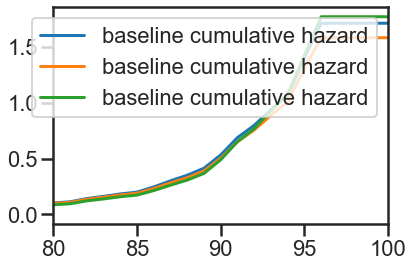

In [63]:
ax = cph_bl.baseline_cumulative_hazard_.plot()
cph_bl_dep.baseline_cumulative_hazard_.plot(ax=ax,)
cph_bl_dep_sleep.baseline_cumulative_hazard_.plot(ax=ax,)
ax.set_xlim(80,100)

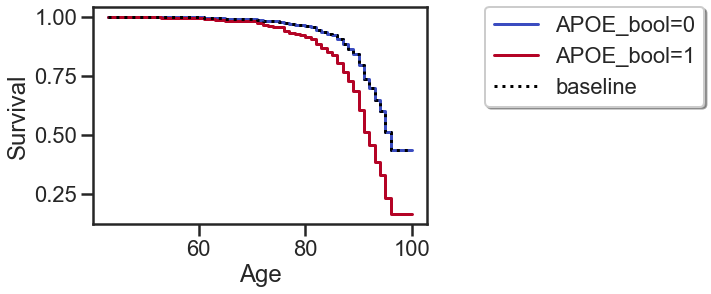

In [82]:
ax=cph_bl_dep_sleep.plot_partial_effects_on_outcome('APOE_bool', range(0, 2, 1), cmap='coolwarm', )
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05),
          ncol=1, fancybox=True, shadow=True)

plt.xlabel("Age")
plt.ylabel("Survival")

plt.show()

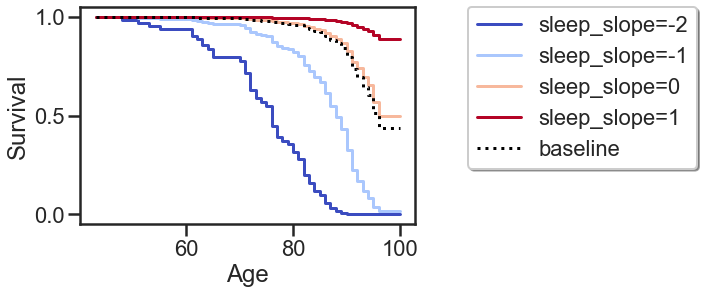

In [84]:
ax=cph_bl_dep_sleep.plot_partial_effects_on_outcome('sleep_slope', range(-2, 2, 1), cmap='coolwarm', )
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05),
          ncol=1, fancybox=True, shadow=True)

plt.xlabel("Age")
plt.ylabel("Survival")

plt.show()

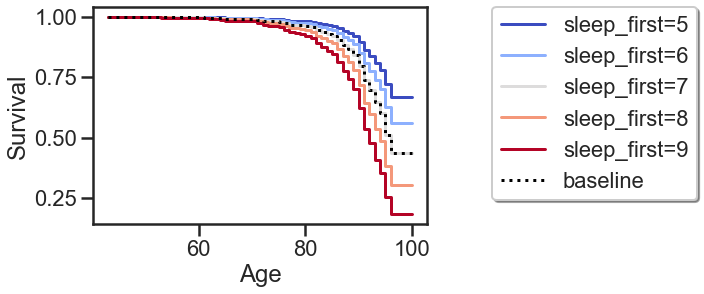

In [65]:
ax=cph_bl_dep_sleep.plot_partial_effects_on_outcome('sleep_first', range(5, 10, 1), cmap='coolwarm', )
ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05),
          ncol=1, fancybox=True, shadow=True)

plt.xlabel("Age")
plt.ylabel("Survival")

plt.show()

<AxesSubplot:xlabel='log(HR) (95% CI)'>

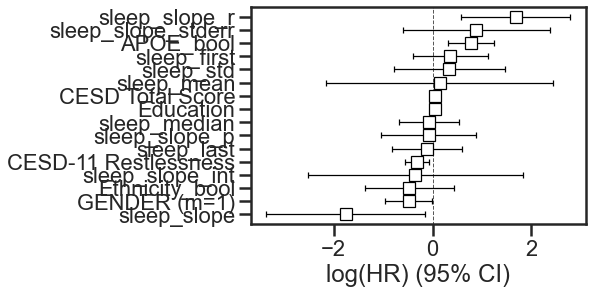

In [67]:
cph_bl_dep_sleep.plot()

In [70]:
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

cph = CoxPHFitter().fit(data_simple, 'test_age', 'dementia')
llf = LogLogisticAFTFitter().fit(data_simple, 'test_age', 'dementia')
lnf = LogNormalAFTFitter().fit(data_simple, 'test_age', 'dementia')
wf = WeibullAFTFitter().fit(data_simple, 'test_age', 'dementia')

print(cph.AIC_partial_)  
print(llf.AIC_)  
print(lnf.AIC_) 
print(wf.AIC_)   

wf.print_summary() 

875.4035723873311
918.1370218313004
944.7167643305334
905.6596886762143


<lifelines.WeibullAFTFitter: fitted with 586 total observations, 493 right-censored observations>
             duration col = 'test_age'
                event col = 'dementia'
   number of observations = 586
number of events observed = 93
           log-likelihood = -434.83
         time fit was run = 2021-11-20 01:23:26 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                    
lambda_ APOE_bool             -0.05       0.95       0.02            -0.09            -0.02                 0.92                 0.98
        CESD Total Score      -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
        CESD-11 Restlessness   0.02       1.03       0.01             0.01             0.04                 1.01                 1.04
        Education             -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
        Ethnicity_bool         0.04       1.05       0.03            -0.02             0.11                 0.98                 1.12
        GENDER (m=1)           0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
        sleep_first           -0.03       0.97       0.03            -0.09             0.03                 0.92                 1.03
        sleep_last             0.01       1.01       0.03            -0.05             0.06                 0.95                 1.06
        sleep_mean            -0.01       0.99       0.09            -0.18             0.16                 0.83                 1.18
        sleep_median           0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
        sleep_slope            0.14       1.15       0.06             0.01             0.26                 1.01                 1.30
        sleep_slope_int        0.03       1.03       0.08            -0.13             0.19                 0.87                 1.21
        sleep_slope_p          0.01       1.01       0.04            -0.06             0.08                 0.94                 1.09
        sleep_slope_r         -0.12       0.88       0.04            -0.21            -0.04                 0.81                 0.96
        sleep_slope_stderr    -0.08       0.93       0.06            -0.19             0.04                 0.82                 1.04
        sleep_std             -0.03       0.97       0.04            -0.11             0.06                 0.89                 1.06
        Intercept              4.52      92.14       0.12             4.30             4.75                73.51               115.48
rho_    Intercept              2.57      13.06       0.07             2.42             2.72                11.29                15.11

                                 z      p   -log2(p)
param   covariate                                   
lambda_ APOE_bool            -2.94 <0.005       8.24
        CESD Total Score     -2.98 <0.005       8.45
        CESD-11 Restlessness  2.60   0.01       6.76
        Education            -0.99   0.32       1.64
        Ethnicity_bool        1.32   0.19       2.42
        GENDER (m=1)          1.98   0.05       4.39
        sleep_first          -0.96   0.34       1.56
        sleep_last            0.24   0.81       0.31
        sleep_mean           -0.13   0.90       0.15
        sleep_median          0.30   0.77       0.38
        sleep_slope           2.19   0.03       5.14
        sleep_slope_int       0.36   0.72       0.48
        sleep_slope_p         0.25   0.80       0.32
        sleep_slope_r        -2.84 <0.005       7.78
        sleep_slope_stderr   -1.29   0.20       2.34
        sleep_std            -0.62   0.54       0.90
        Intercept            39.2

## cluster 

In [ ]:
data_final_nona.columns.values

In [85]:
sleep_cluster = data_final_nona[['CESD-11 Restlessness', 
                               'sleep_first', 'sleep_last', 'sleep_mean',
       'sleep_std', 'sleep_slope', 'sleep_slope_int',
       ]]

# center and scale the data
scaler = StandardScaler()
#scaler = RobustScaler()

sleep_cluster_scaled = scaler.fit_transform(sleep_cluster)

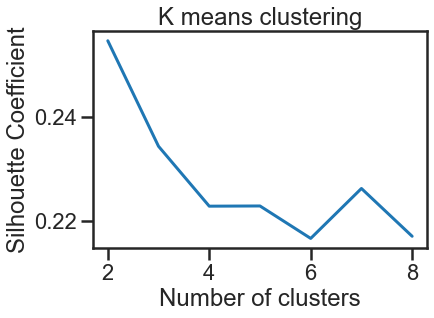

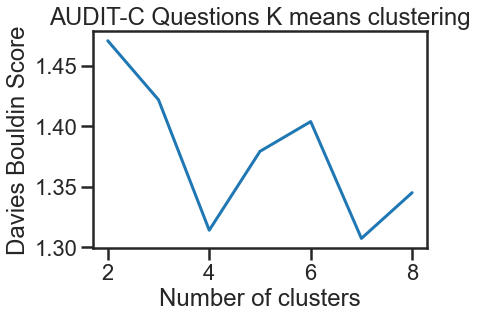

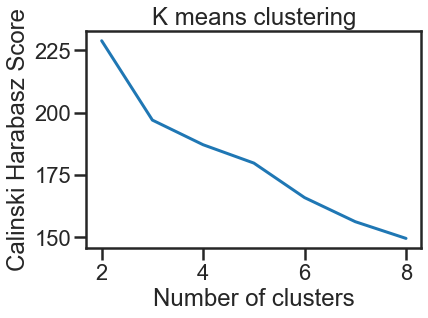

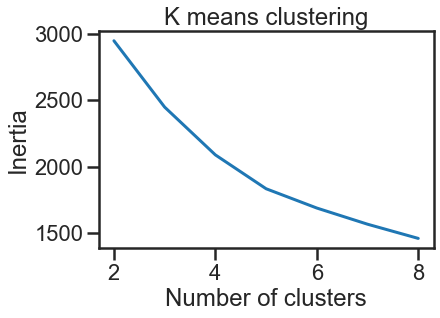

In [86]:
data = sleep_cluster_scaled

#pick cluster number based on silhouette coefficient
k_range = range(2,9)

base_scores = []
sil_scores = []
db_scores = []
ch_scores = []
mse_scores = []

for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=39)
    km_ss.fit(data)
    
    base_scores.append(-km_ss.score(data))
    sil_scores.append(metrics.silhouette_score(data, km_ss.labels_))
    db_scores.append(metrics.davies_bouldin_score(data, km_ss.labels_))
    ch_scores.append(metrics.calinski_harabasz_score(data, km_ss.labels_))
    mse_scores.append(km_ss.inertia_)
    

# plot the results
plt.plot(k_range, sil_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# plot the results
plt.plot(k_range, db_scores)
plt.title('AUDIT-C Questions K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

# plot the results
plt.plot(k_range, ch_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()
    
# plot the results
plt.plot(k_range, mse_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

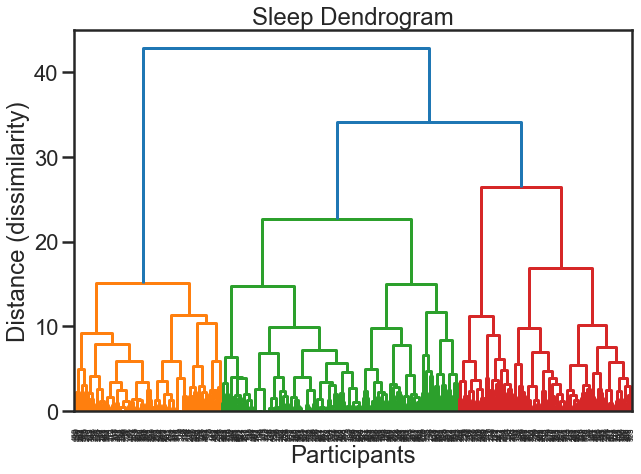

In [87]:
#viz dendrogram to find if three clusters makes sense
plt.figure(figsize=(10, 7))  
plt.title("Sleep Dendrogram")  
plt.ylabel("Distance (dissimilarity)")
plt.xlabel("Participants")
dend = shc.dendrogram(shc.linkage(sleep_cluster_scaled, method='ward'), 
                      distance_sort='ascending',
                      show_leaf_counts=True, leaf_font_size=8)

In [88]:
#choose k=3 clusters and fit data
km_3 = KMeans(n_clusters=3,random_state=99)
km_3.fit(sleep_cluster_scaled)

data_final_nona['kmeans_cluster'] = ["cluster_" + str(label) for label in km_3.labels_ ]
print(data_final_nona.shape)
data_final_nona.head(1)

(586, 31)


,IDNUM,SLS #,BIRTHYR,COHORT,Ethnicity,GENDER (m=1),APOE Status,Education,OCCSN,OCCSNDT,test_age,dementia,sleep_keep,sleep_count,sleep_count_final,sleep_first,sleep_last,sleep_mean,sleep_median,sleep_std,sleep_slope,sleep_slope_int,sleep_slope_r,sleep_slope_p,sleep_slope_stderr,CESD-11 Restlessness,CESD Total Score,APOE_bool,Ethnicity_bool,dementia_bool,kmeans_cluster
9,127504,127504,1934,7,1.0,2,2/4,20,3,2007.0,73.0,1,1,3,3,8.0,8.0,8.0,8.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,7.0,1,1,True,cluster_2


In [89]:
data_final_nona.groupby('kmeans_cluster')['dementia'].value_counts()

kmeans_cluster  dementia
cluster_0       0           122
                1           23 
cluster_1       0           183
                1           33 
cluster_2       0           188
                1           37 
Name: dementia, dtype: int64

IDNUM


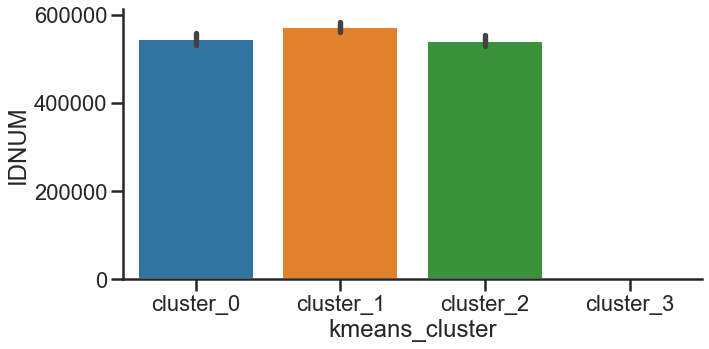

SLS #


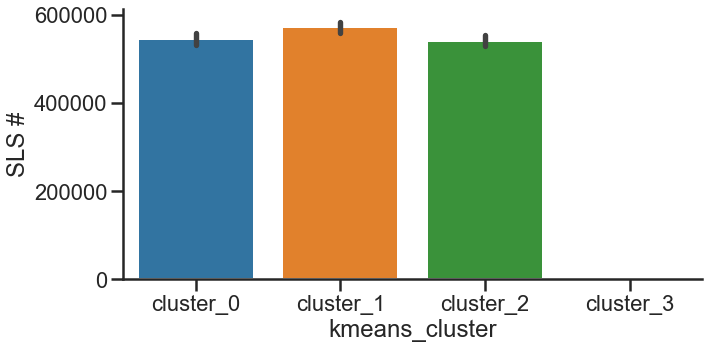

BIRTHYR


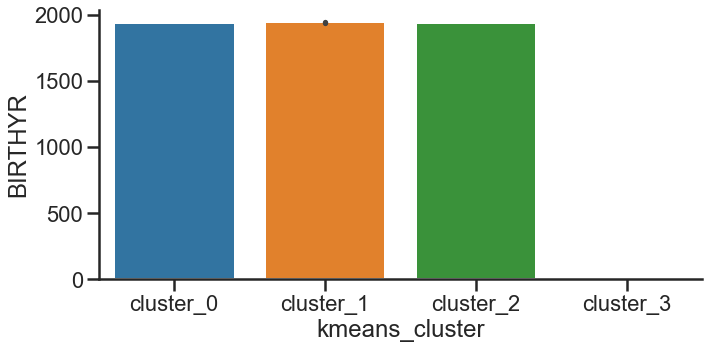

COHORT


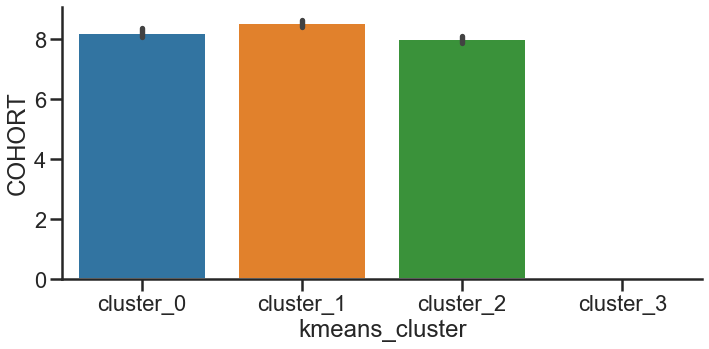

Ethnicity


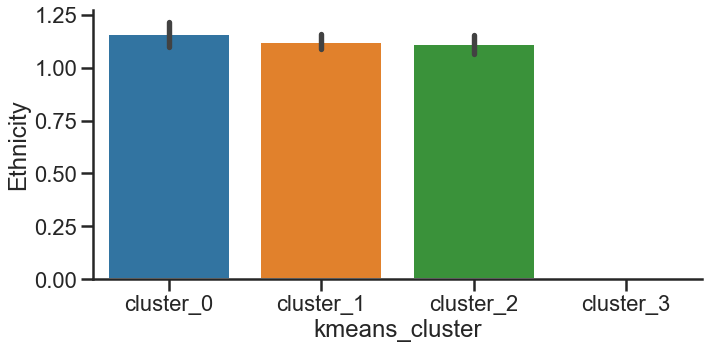

GENDER (m=1)


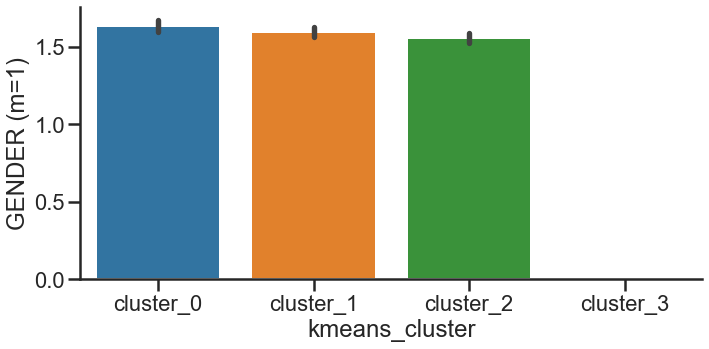

APOE Status
no
Education


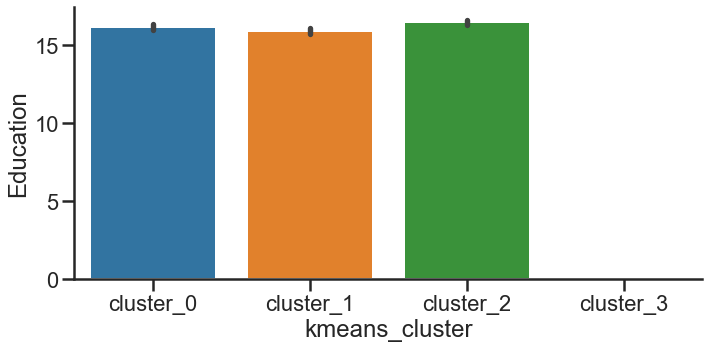

OCCSN


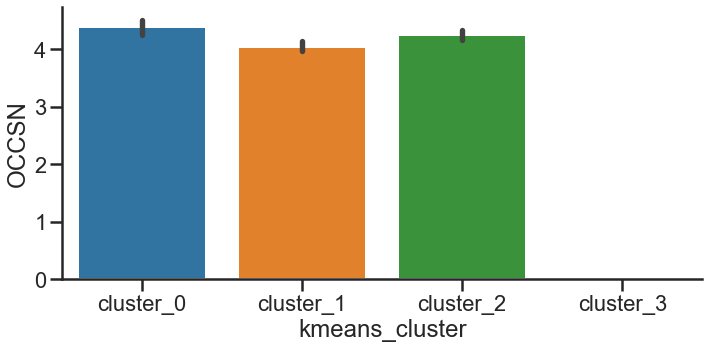

OCCSNDT


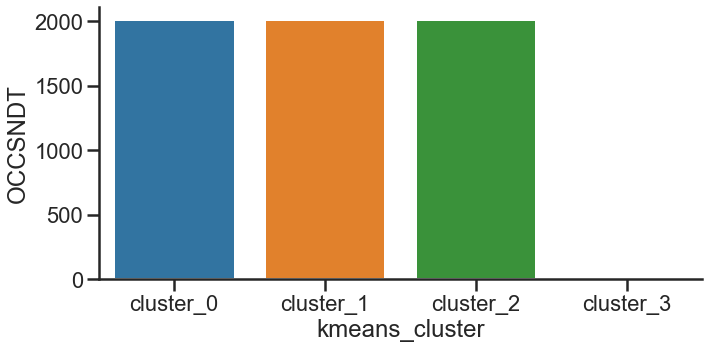

test_age


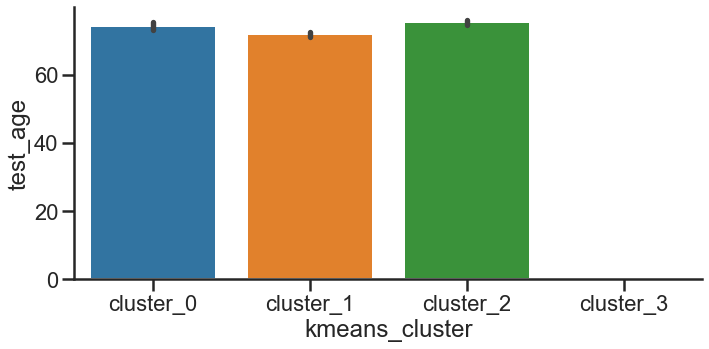

dementia


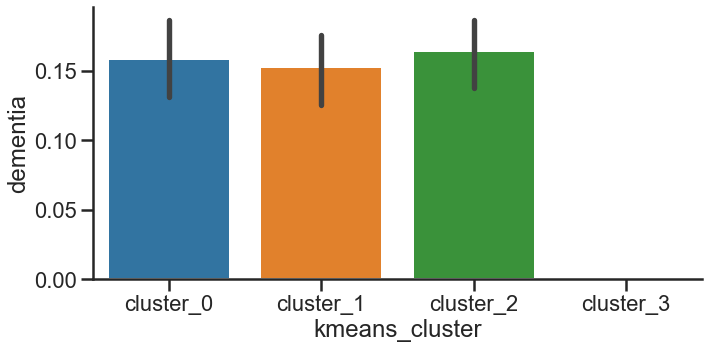

sleep_keep


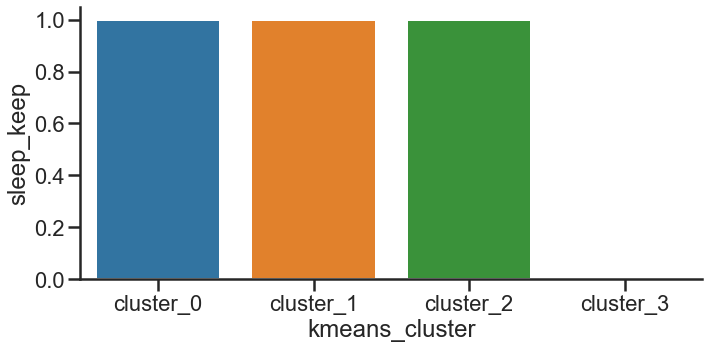

sleep_count


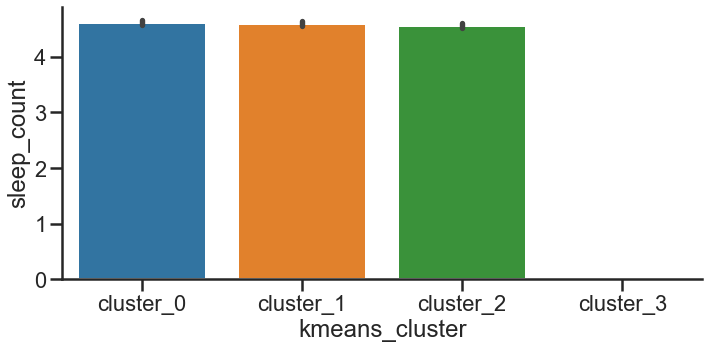

sleep_count_final


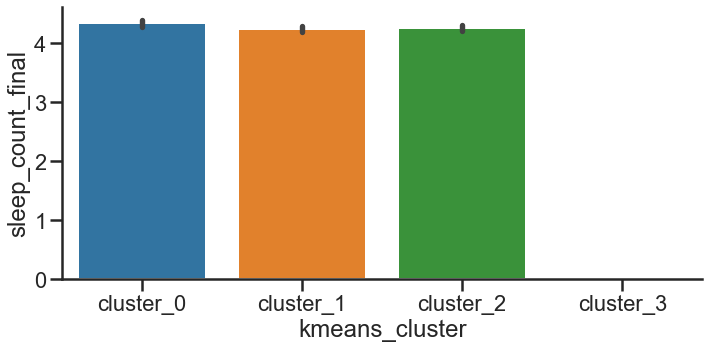

sleep_first


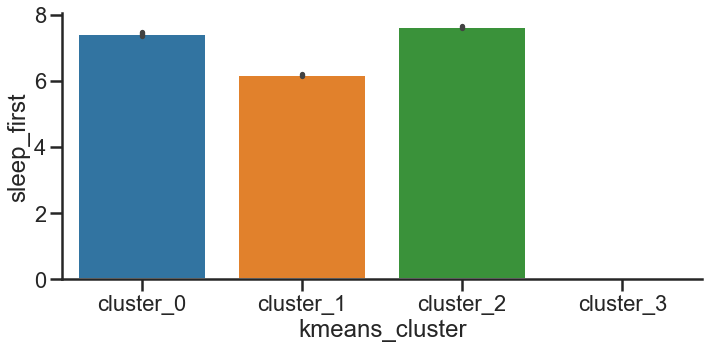

sleep_last


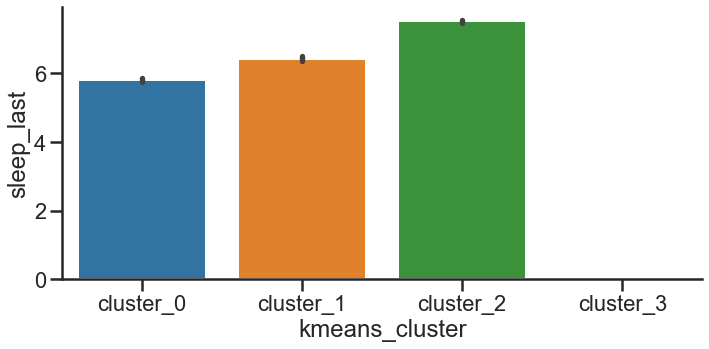

sleep_mean


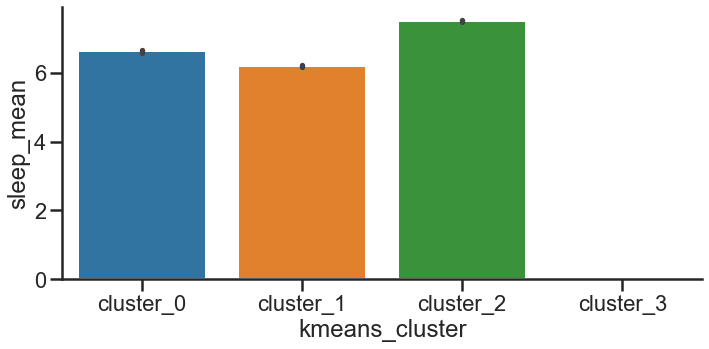

sleep_median


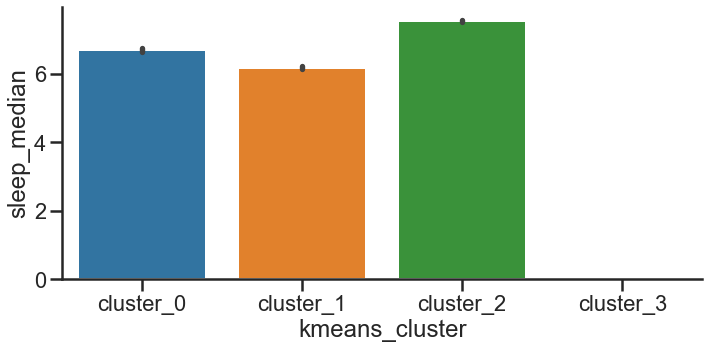

sleep_std


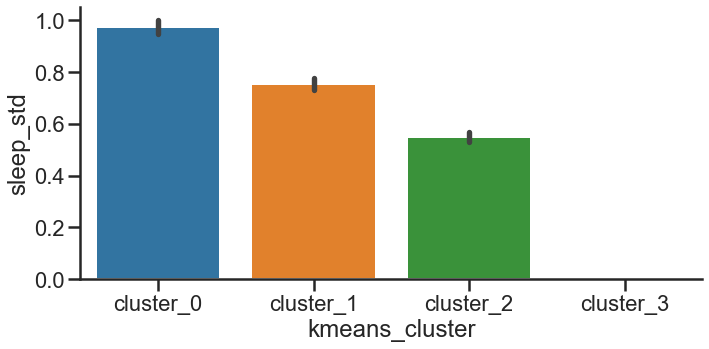

sleep_slope


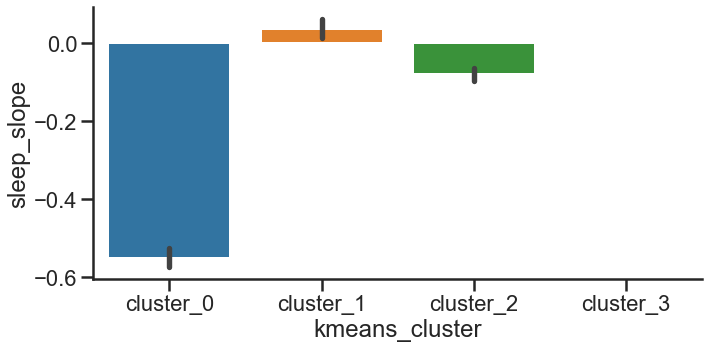

sleep_slope_int


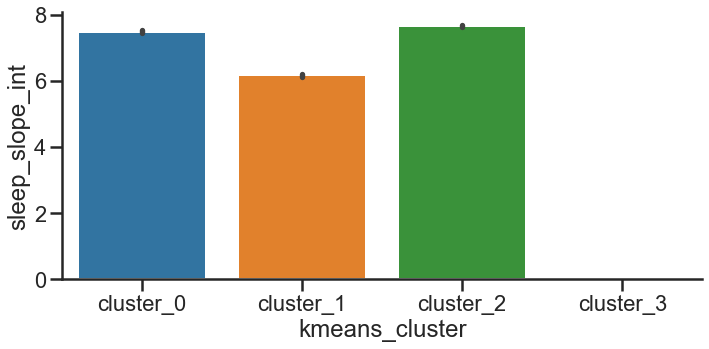

sleep_slope_r


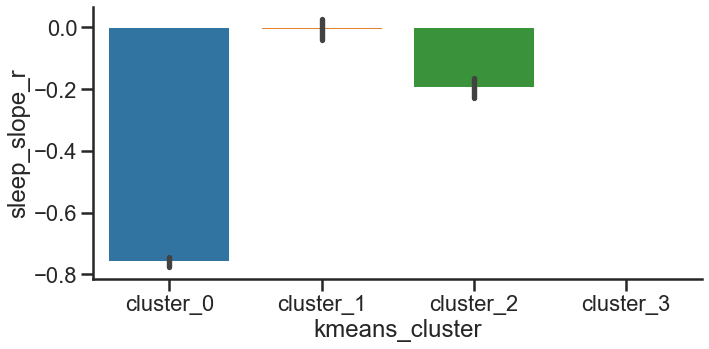

sleep_slope_p


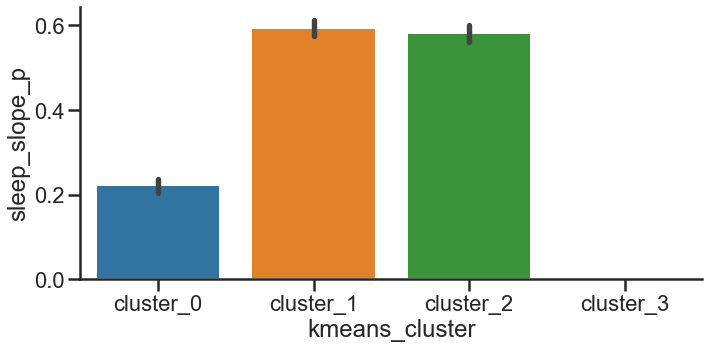

sleep_slope_stderr


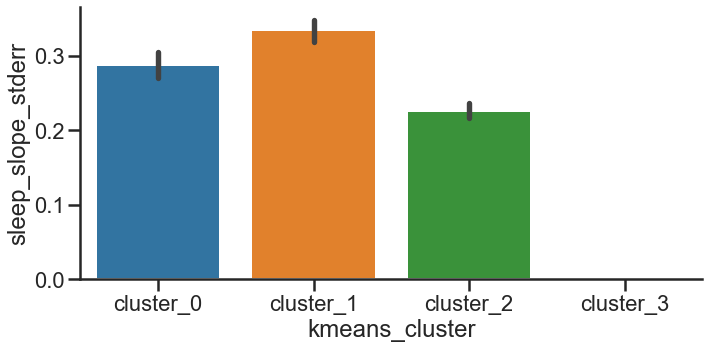

CESD-11 Restlessness


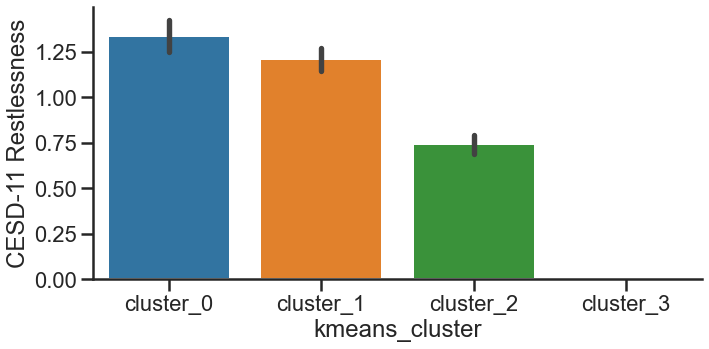

CESD Total Score


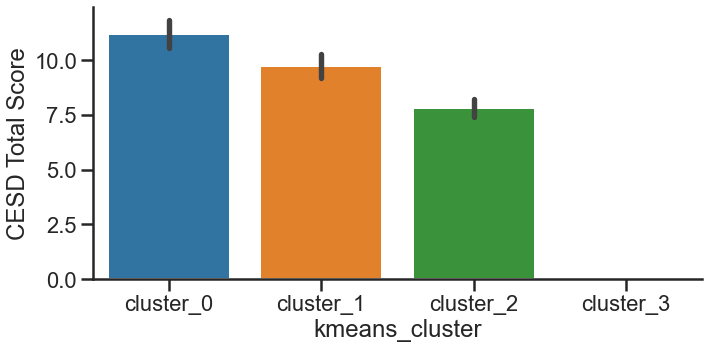

APOE_bool


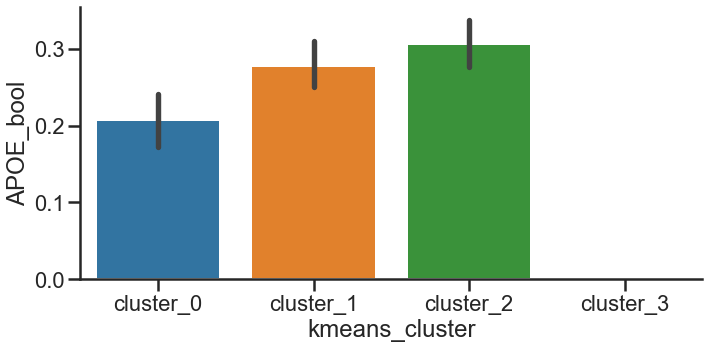

Ethnicity_bool


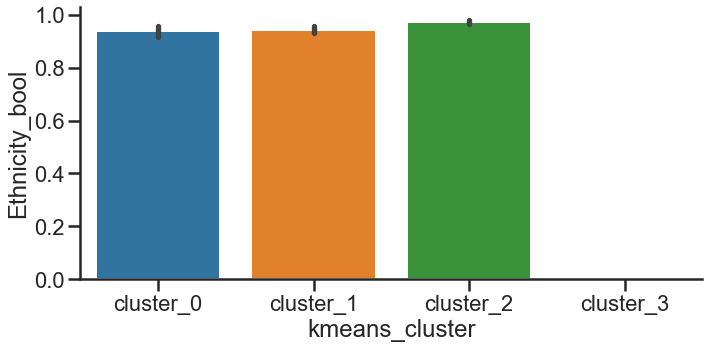

dementia_bool


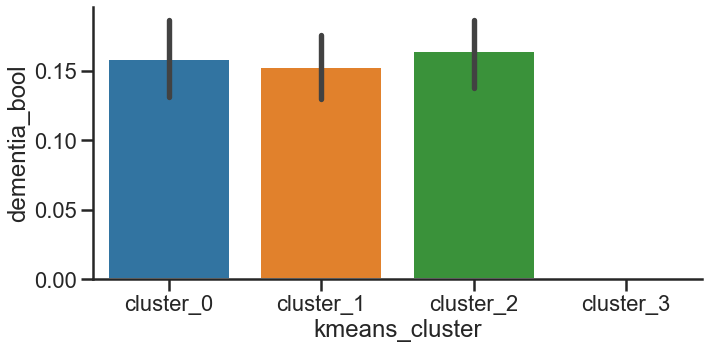

kmeans_cluster
no


In [90]:
for col in data_final_nona.columns.values:
    print(col)
    try:
        sns.catplot(x='kmeans_cluster', y=col, kind='bar', ci=68, data=data_final_nona, height=5, aspect=2, order=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])
        plt.show()
    except:
        print('no')

## predict 

In [ ]:
predict = final_data_moments[['dementia', 'Education', 'APOE', 'Age at Death', 'GENDER', 'Ethnicity', 
                    'dep_med', 'sleep_std', 'sleep_slope', 'sleep_ave', 'sleep_first',
                             'sleep_group', 'CERAD SCORE', 'BRAAK',]].dropna(axis=0)

print(predict.shape)
predict.head()

In [ ]:
predict['GENDER'].value_counts()

## dementia binary

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.neighbors import KNeighborsClassifier 
import xgboost as xgb

from sklearn.feature_selection import RFECV

import shap
# load JS visualization code to notebook
shap.initjs()

In [ ]:
predict['APOE'] = [1 if '4' in x.split('/') else 0 for x in  predict['APOE']]
predict['dementia'] = [1 if x=='Yes' else 0 for x in  predict['dementia']]


In [ ]:
#split data
train, test = train_test_split(predict, test_size = .3, random_state=39, stratify = predict['dementia'])

Y_train = train['dementia']
Y_test = test['dementia']

#create feature sets
features = ['Education', 'APOE', 'Age at Death', 'GENDER', 'Ethnicity', 
                    'dep_med', 'sleep_std', 'sleep_slope', 'sleep_ave', 'sleep_first']

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)


In [ ]:
#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)

#classifier algos
dm = DummyClassifier(strategy='stratified', random_state=39)
lr = LogisticRegression(random_state=39, class_weight='balanced')
rf = RandomForestClassifier(random_state=39, class_weight='balanced')
svm = SVC(kernel='rbf', probability=True, class_weight='balanced') 
knn = KNeighborsClassifier(n_neighbors=5)
gb = GradientBoostingClassifier(random_state=39)
ab = AdaBoostClassifier(random_state=39)

model = knn 

#generate cross-val sets
cv = list(strat_k_fold.split(train_scaled, Y_train))
    
#predict class and predict probability 
y_pred = cross_val_predict(model, train_scaled, Y_train, cv=cv, method='predict')
y_pred_prob = cross_val_predict(model, train_scaled, Y_train, cv=cv, method='predict_proba')

#generate ROC_AUC
ROC_AUC = metrics.roc_auc_score(Y_train, y_pred)
print("ROC_AUC: ", ROC_AUC)    

#generate confusion matrix
conf_mat = confusion_matrix(Y_train, y_pred)
print('Confusion matrix:\n', conf_mat)

# generate additional metrics
recall = metrics.recall_score(Y_train,y_pred, average='weighted')
precision = metrics.precision_score(Y_train,y_pred, average='weighted')
accuracy = metrics.accuracy_score(Y_train,y_pred)
F1 = metrics.f1_score(Y_train,y_pred, average='weighted')
print("Sensitivity/Recall (TPR): ",recall)
print("Precision (PPV): ", precision)
print("Accuracy: ", accuracy)
print("F1:", F1)
    
model.fit(train_scaled, Y_train)

In [ ]:
#scale data for grid search
explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

In [ ]:
shap.summary_plot(shap_values, X_train)

## predict CERAD regression

In [ ]:
#split data
train, test = train_test_split(predict, test_size = .3, random_state=39, stratify = predict['BRAAK'])

Y_train = train['BRAAK']
Y_test = test['BRAAK']

#create feature sets
features = ['Education', 'APOE', 'Age at Death', 'GENDER', 'Ethnicity', 
                    'dep_med', 'sleep_std', 'sleep_slope', 'sleep_ave', 'sleep_first']

X_train = train[features]
X_test = test[features]

#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=10)

#scale data 
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)


In [ ]:

# evaluate random forest algorithm for classification
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# define the model
model = DummyRegressor()
model = RandomForestRegressor()
#model = AdaBoostRegressor()
#model = KNeighborsRegressor(n_neighbors=5)

# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=39)
n_scores = cross_val_score(model, train_scaled, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE = %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

reg = model.fit(train_scaled, Y_train)
print('R2 = ', reg.score(train_scaled, Y_train))

In [ ]:
#scale data for grid search
explainer = shap.KernelExplainer(model.predict, train_scaled)
shap_values = explainer.shap_values(train_scaled)

In [ ]:
shap.summary_plot(shap_values, X_train)